In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.decomposition import PCA

In [2]:
def get_mbs_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    mbs_path = os.path.join(data_path, "MBS.parquet")

    renamer = {
        "LUMSMD": "MBS_mod_dur",
        "LUMSOAS": "MBS_oas",
        "LUMSTRUU": "MBS_index"}

    df_mbs = (pd.read_parquet(
        path = mbs_path, engine = "pyarrow").
        rename(columns = renamer).
        reset_index().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_mbs

df_mbs = get_mbs_data()

In [3]:
def get_tsy_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    tsy_path = os.path.join(data_path, "tsy.parquet")

    df_tsy = (pd.read_parquet(
        path = tsy_path, engine = "pyarrow").
        rename(columns = {
            "CONVENTIONAL_CTD_FORWARD_FRSK": "ctd_duration",
            "FUT_EQV_CNVX_NOTL": "ctd_convexity"}).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_tsy

df_tsy = get_tsy_data()

# Treasury Trend Following Models

Start by creating a series of Treasury Trend following models. To simplify these models we'll use a simplified EMA Crossover. The complexity of the trend following models is not of upmost importance. The approach to this model is to show that some added modelling of the treasury-leg of the MBS basis can lead to a suitable outperformance. I'll use the following moving averages [64&256, 32&128, 16&64, 8&32]. These windows are the windows prescribed within the Advanced Futures Trading Strategies - Carver book (pg.186).

In [4]:
def _trend(df: pd.DataFrame, short_window: int, long_window: int) -> pd.DataFrame: 

    '''
    Trend Function per specific security and specific lookback windows
    '''
    
    df_out = (df.sort_index().assign(
        short_ma = lambda x: x.PX_LAST.ewm(span = short_window, adjust = False).mean(),
        long_ma = lambda x: x.PX_LAST.ewm(span = long_window, adjust = False).mean(),
        price_std = lambda x: x.PX_LAST.ewm(span = long_window, adjust = False).std(),
        signal = lambda x: (x.short_ma - x.long_ma) / x.price_std,
        lag_signal = lambda x: x.signal.shift(),
        short_window = short_window,
        long_window = long_window).
        drop(columns = ["short_ma", "long_ma", "price_std"]).
        dropna())
    
    return df_out
    
def _get_trend_signal(df: pd.DataFrame, lookback_windows: list) -> pd.DataFrame:
    
    '''
    Trend Function per security and n lookback windows
    '''
    
    df_out = (pd.concat([_trend(
        df, lookback_window["short_window"], lookback_window["long_window"])
        for lookback_window in lookback_windows]).
        drop(columns = ["security"]))
    
    return df_out

def get_trend_signal(df_tsy: pd.DataFrame, start: int = 3, stop: int = 7) -> pd.DataFrame: 
    
    '''
    Trend function n securities and n lookback windows
    '''
    
    lookback_windows = [
        {"short_window": 2 ** i, "long_window": 2 ** (i + 2)} 
        for i in range(start, stop)]
    
    df_trend = (df_tsy.drop(
        columns = ["ctd_duration", "ctd_convexity"]).
        groupby("security").
        apply(_get_trend_signal, lookback_windows).
        reset_index())
    
    return df_trend

df_trend = get_trend_signal(df_tsy)

In [5]:
def get_longer_strat(df: pd.DataFrame) -> pd.DataFrame:
    
    df_longer = (df_trend.assign(
        strat = lambda x: 
        x.security + " " + 
        x.short_window.astype(str) + "&" + x.long_window.astype(str))
        [["strat", "date", "lag_signal"]])
    
    return df_longer

def get_correaltion_matrix(df_trend: pd.DataFrame) -> pd.DataFrame:
    
    df_corr = (get_longer_strat(df_trend).pivot(
        index = "date", columns = "strat", values = "lag_signal").
        cov())
    
    return df_corr

df_corr = get_correaltion_matrix(df_trend)

In [6]:
def get_pca(df_trend: pd.DataFrame) -> pd.DataFrame: 
    
    df_wider = (get_longer_strat(
        df_trend).
        pivot(index = "date", columns = "strat", values = "lag_signal").
        fillna(0))

    df_exp = (pd.DataFrame({
        "PC": [i + 1 for i in range(len(df_wider.columns))],
        "exp_variance": PCA(
            n_components = len(df_wider.columns)).
            fit(df_wider).
            explained_variance_ratio_}).
        set_index("PC"))
    
    return df_exp

df_exp = get_pca(df_trend)

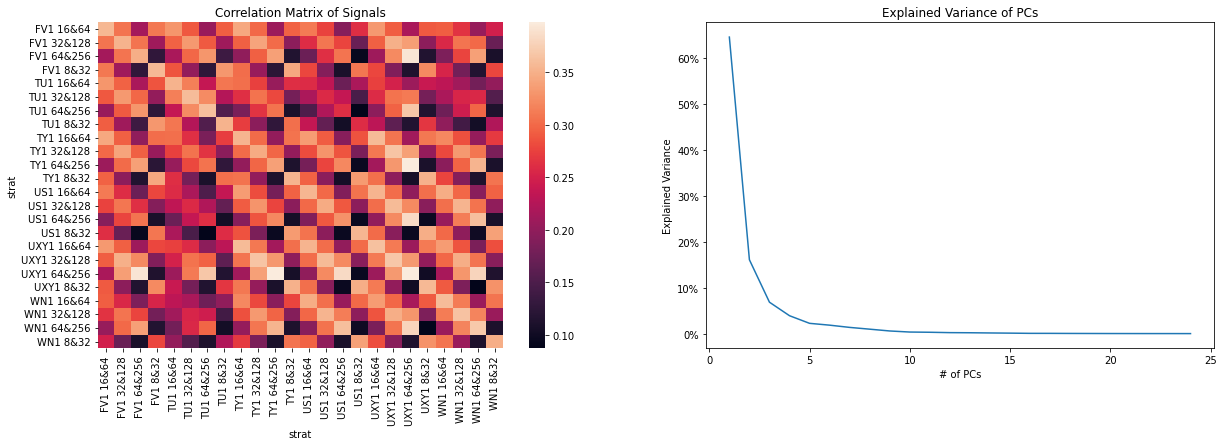

In [7]:
def plot_signal_attributes(df_corr: pd.DataFrame, df_exp: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    sns.heatmap(
        df_corr, 
        ax = axes[0])

    df_exp.plot(
        ax = axes[1],
        xlabel = "# of PCs",
        ylabel = "Explained Variance",
        title = "Explained Variance of PCs",
        legend = False)

    axes[0].set_title("Correlation Matrix of Signals")
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
plot_signal_attributes(df_corr, df_exp)

Although there are various CTA signals and lookbacks, instead of looking at the individual signals of each security start by averaging the signal across securities. Start with a long basis model where we are always picking the CTA that is short the Treasury that is the closest in duration to the MBS. 

In [8]:
def get_avg_trend(df_trend: pd.DataFrame) -> pd.DataFrame:     

    df_avg_trend = (df_trend[
        ["security", "date", "lag_signal"]].
        groupby(["date", "security"]).
        agg("mean").
        reset_index())
    
    return df_avg_trend

df_avg_trend = get_avg_trend(df_trend)

When creating the signal there are a couple of considerations. The first is that certain Treasury Futures have different start dates. That will be left as-is, since that'd be the most accurate to what would've played out and make the backtest more realistic. There are some periods where there aren't any CTA signals that are short treasuries. In that case the optimal Treasury will be the one with lowest signal. 

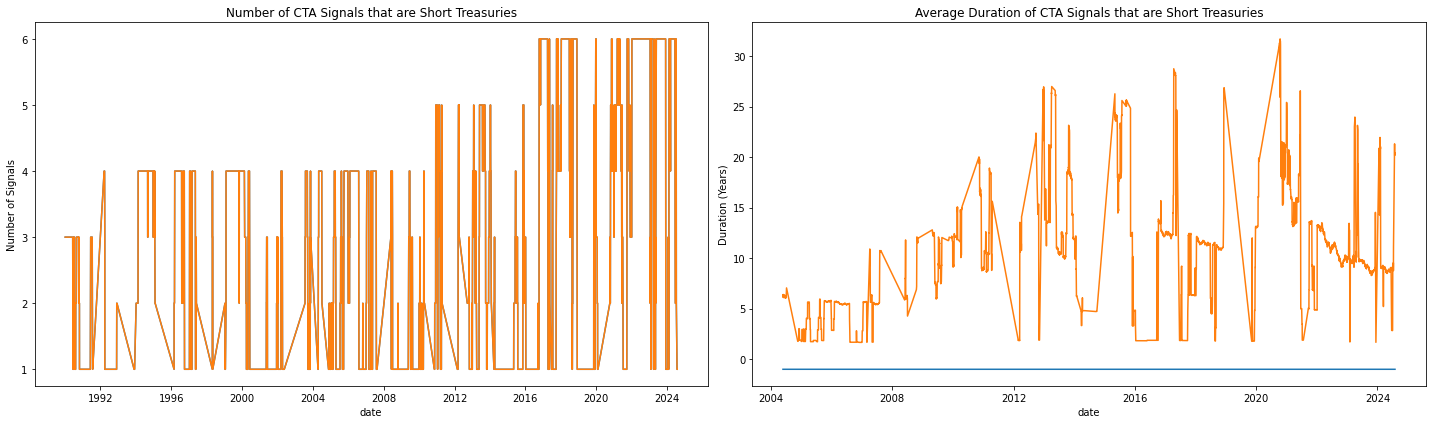

In [9]:
def plot_negative_signal_statistics(df_avg_trend: pd.DataFrame, df_tsy: pd.DataFrame) -> plt.Figure: 
    
    df_num_signals = (df_avg_trend.assign(
        signal = lambda x: np.sign(x.lag_signal)).
        query("signal == -1").
        drop(columns = ["security"]).
        groupby("date").
        agg("count"))

    df_tsy_duration = (df_tsy[
        ["security", "ctd_duration"]].
        dropna())

    df_neg_cta = (df_avg_trend.assign(
        signal = lambda x: np.sign(x.lag_signal)).
        query("signal == -1"))

    df_cta_duration = (df_neg_cta.merge(
        right = df_tsy_duration, how = "inner", on = ["date", "security"]).
        drop(columns = ["lag_signal", "security"]).
        groupby("date").
        agg("mean"))

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    (df_num_signals.plot(
        ax = axes[0],
        legend = False,
        ylabel = "Number of Signals",
        title = "Number of CTA Signals that are Short Treasuries"))

    (df_cta_duration.plot(
        ax = axes[1],
        legend = False,
        ylabel = "Duration (Years)",
        title = "Average Duration of CTA Signals that are Short Treasuries"))
    
    plt.tight_layout()
    
plot_negative_signal_statistics(df_avg_trend, df_tsy)

Let's start by finding the Treasury that has the smallest signal as the optimal short candidate. 

In [10]:
def _get_min_signal(df: pd.DataFrame) -> pd.DataFrame: return(df.query("lag_signal == lag_signal.min()"))

def get_min_signal(df_tsy: pd.DataFrame, df_avg_trend: pd.DataFrame) -> pd.DataFrame: 

    df_avg_min_signal = (df_tsy.drop(
        columns = ["ctd_convexity", "ctd_duration"]).
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "rtn"}).
        merge(right = df_tsy[["security", "ctd_duration"]], how = "inner", on = ["date", "security"]).
        dropna().
        merge(right = df_avg_trend, how = "inner", on = ["date", "security"]).
        groupby("date").
        apply(_get_min_signal).
        reset_index(drop = True))
    
    return df_avg_min_signal

df_avg_min_signal = get_min_signal(df_tsy, df_avg_trend)

Let's look at the performance of our signal, as well as its duration compared to their MBS, this will be done always assuming we are short the treasury. This strategy will be compared against all other Treasuries on a full historical basis and using the startest date of the lastest issued Treasury future.

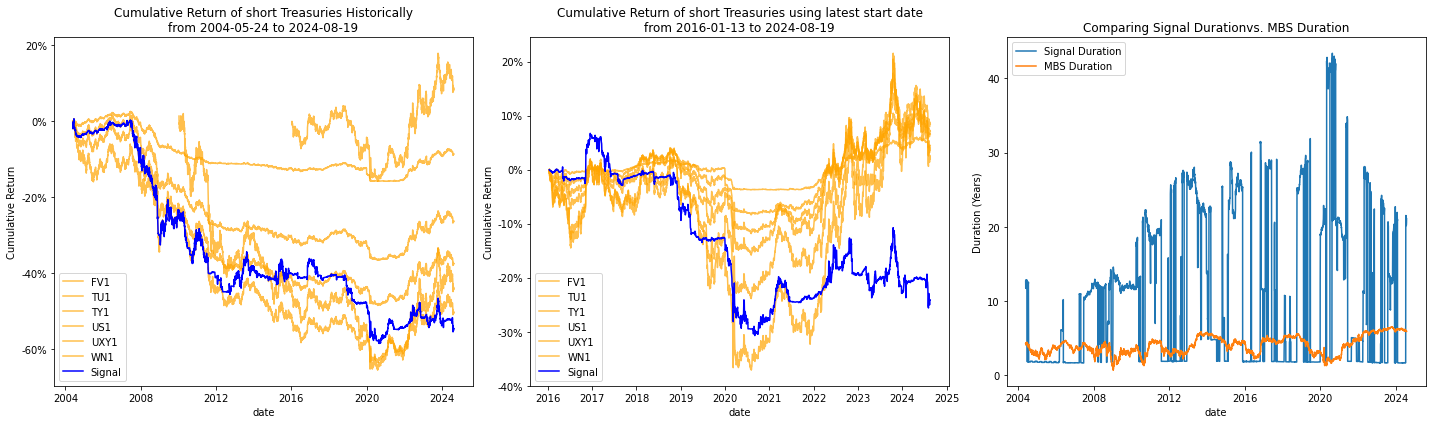

In [11]:
def plot_signal_returns(df_avg_min_signal: pd.DataFrame, df_tsy: pd.DataFrame) -> plt.Figure:
    
    df_signal_rtn = (df_avg_min_signal.assign(
        signal_rtn = lambda x: -1 * x.rtn)
        [["date", "signal_rtn"]])

    df_combined_rtn = (df_tsy[
        ["security", "PX_LAST"]].
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change().
        apply(lambda y: -1 * y).
        reset_index().
        merge(right = df_signal_rtn, how = "inner", on = ["date"]).
        rename(columns = {"signal_rtn": "Signal"}))

    df_combined_duration = (df_avg_min_signal[
        ["date", "ctd_duration"]].
        merge(right = df_mbs, how = "inner", on = ["date"]).
        set_index("date")
        [["ctd_duration", "MBS_mod_dur"]].
        rename(columns = {
            "ctd_duration": "Signal Duration",
            "MBS_mod_dur": "MBS Duration"}))

    fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

    df_full_combined = (df_combined_rtn.drop(
        columns = ["Signal"]).
        set_index("date").
        apply(lambda x: np.cumprod(1 + x) - 1))

    df_start_combined = (df_combined_rtn.dropna().drop(
        columns = ["Signal"]).
        set_index("date").
        apply(lambda x: np.cumprod(1 + x) - 1))

    (df_start_combined.plot(
        ax = axes[1],
        color = "orange",
        alpha = 0.7))

    (df_full_combined.plot(
        ax = axes[0],
        color = "orange",
        alpha = 0.7))

    (df_combined_rtn[
        ["date", "Signal"]].
        set_index("date").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            color = "blue",
            ylabel = "Cumulative Return",
            title = "Cumulative Return of short Treasuries Historically\nfrom {} to {}".format(
                df_combined_rtn.date.min(),
                df_combined_rtn.date.max())))

    (df_combined_rtn.dropna().set_index(
        "date")
        [["Signal"]].
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[1],
            color = "blue",
            ylabel = "Cumulative Return",
            title = "Cumulative Return of short Treasuries using latest start date\nfrom {} to {}".format(
                df_start_combined.index.min(),
                df_start_combined.index.max())))

    (df_combined_duration.plot(
        ax = axes[2],
        ylabel = "Duration (Years)",
        title = "Comparing Signal Durationvs. MBS Duration"))
    
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()
    
plot_signal_returns(df_avg_min_signal, df_tsy)

It is evident that although the trading strategy minimizes the loss (particularly in the full history not necessarily in the second graph), the duration is to unstable and therefore the duration hedging as well as the transaction costs of switching short legs will eat against the gains. 